# RTBT emittance measurement data analysis 
> 05.31.2021

In [47]:
import sys

import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import proplot as plot
from pprint import pprint

sys.path.append('/Users/46h/Research/code/')
from accphys.tools import utils
from accphys.tools import beam_analysis as ba 

sys.path.append('/Users/46h/Research/code/accphys/pyorbit/measurement/')
from data_analysis import reconstruct

In [48]:
plot.rc['grid.alpha'] = 0.04
plot.rc['figure.facecolor'] = 'white'

## View Twiss parameters at each scan index 

In [49]:
scan_indices = [0, 1, 3, 7, 11]
twiss_list = [np.loadtxt('./twiss_{}.dat'.format(i)) 
              for i in scan_indices + ['default']]

### Phase advance 

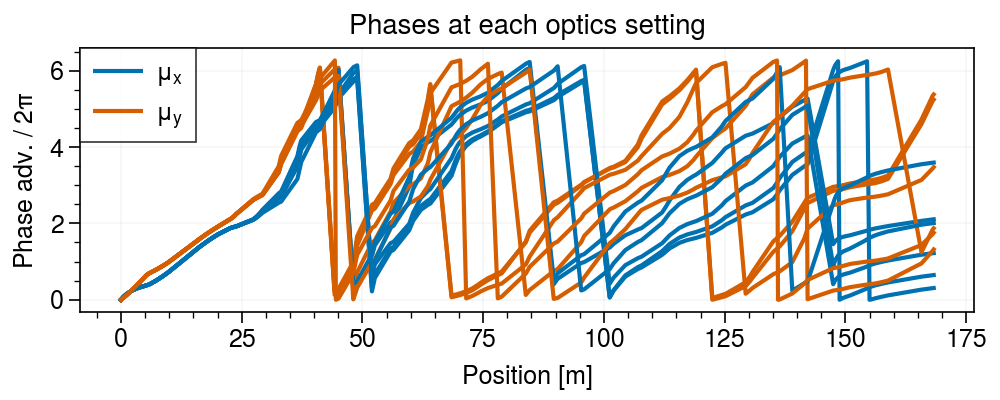

In [50]:
fig, ax = plot.subplots(figsize=(5, 2))
for twiss in twiss_list:
    pos, mu_x, mu_y, alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = twiss.T
    ax.format(cycle='colorblind')
    ax.plot(pos, mu_x)
    ax.plot(pos, mu_y)
ax.legend(labels=[r'$\mu_x$', r'$\mu_y$'], ncols=1);
ax.format(ylabel=r'Phase adv. / 2$\pi$', xlabel='Position [m]',
          title='Phases at each optics setting')

### Beta functions 

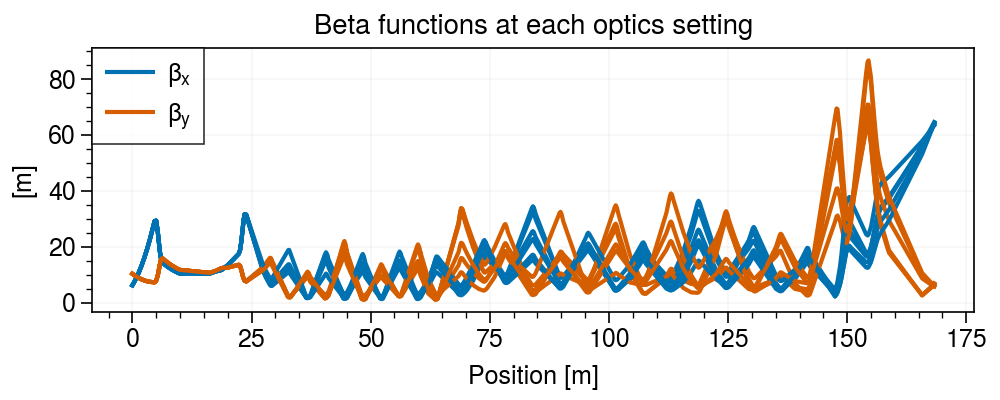

In [51]:
fig, ax = plot.subplots(figsize=(5, 2))
for twiss in twiss_list:
    pos, mu_x, mu_y, alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = twiss.T
    ax.format(cycle='colorblind')
    ax.plot(pos, beta_x)
    ax.plot(pos, beta_y)
ax.legend(labels=[r'$\beta_x$', r'$\beta_y$'], ncols=1);
ax.format(ylabel='[m]', xlabel='Position [m]', 
          title='Beta functions at each optics setting')

## Process wire-scanner data 

We used a 180 degree range for the phase advances, with 12 steps total. We didn't have time to take measurements at each step. The 'Prod' tag means the machine was at its default settings. Then 'scan0' means we started at the first index in the scan, 'scan1' the second index, and so on up to 'scan11'.

In [53]:
ws_ids = ['WS20', 'WS21', 'WS23', 'WS24']
filenames = [fname for fname in utils.list_files('./', join=False) 
             if fname.startswith('Wire')]
filetags = [fname.split('.pta')[0].split('_')[-1] for fname in filenames]
for filename, filetag in zip(filenames, filetags):
    print("tag = {:<7} file = {}".format(filetag, filename))

tag = Prod    file = WireAnalysisFmt-2021.05.31_21.08.18_Prod.pta.txt
tag = scan7   file = WireAnalysisFmt-2021.05.31_21.46.32_scan7.pta.txt
tag = scan0   file = WireAnalysisFmt-2021.05.31_21.34.38_scan0.pta.txt
tag = scan11  file = WireAnalysisFmt-2021.05.31_21.52.00_scan11.pta.txt
tag = scan1   file = WireAnalysisFmt-2021.05.31_21.23.35_scan1.pta.txt
tag = scan3   file = WireAnalysisFmt-2021.05.31_21.40.23_scan3.pta.txt


### Collect raw profiles 

In [54]:
def read_profile_data(filename):
    
    # Collect lines corresponding to each wire-scanner.
    file = open(filename, 'r')
    lines, ws_id = dict(), None
    for line in file:
        line = line.rstrip()
        if line.startswith('RTBT_Diag'):
            ws_id = line.split(':')[-1]
            continue
        lines.setdefault(ws_id, []).append(line)
    file.close()
    
    # Collect intensity readings on each wire.
    data = dict()
    for ws_id in ws_ids:
        # Blank lines separate file into sections
        param_lines, raw_lines, fit_lines = utils.split_list(lines[ws_id], '')[:3]
        # Remove headers ('X Raw', 'Y Raw', etc.) and dashed line that follows.
        raw_lines = raw_lines[2:] 
        data_arr = np.array([[float(string) for string in line.split()] 
                             for line in raw_lines])
        columns = ['pos','xraw','yraw','uraw','x?','y?','u?']
        data[ws_id] = pd.DataFrame(data_arr, columns=columns)
        
    return data

In [55]:
data_list = [read_profile_data(filename) for filename in filenames]
data_list[0]['WS20']

,pos,xraw,yraw,uraw,x?,y?,u?
0,25.0,-0.001058,0.003174,-0.000773,17.67775,17.67775,25.0
1,28.0,-0.000651,0.003540,-0.000732,19.79908,19.79908,28.0
2,31.0,-0.000732,0.003133,-0.000773,21.92041,21.92041,31.0
3,34.0,-0.001221,0.003215,-0.001099,24.04174,24.04174,34.0
4,37.0,-0.000854,0.002889,-0.000610,26.16307,26.16307,37.0
...,...,...,...,...,...,...,...
85,280.0,-0.000895,0.003255,-0.000732,197.99080,197.99080,280.0
86,283.0,-0.001139,0.003418,-0.000732,200.11213,200.11213,283.0
87,286.0,-0.000895,0.003215,-0.000936,202.23346,202.23346,286.0
88,289.0,-0.001058,0.003540,-0.001017,204.35479,204.35479,289.0


### View raw profiles 

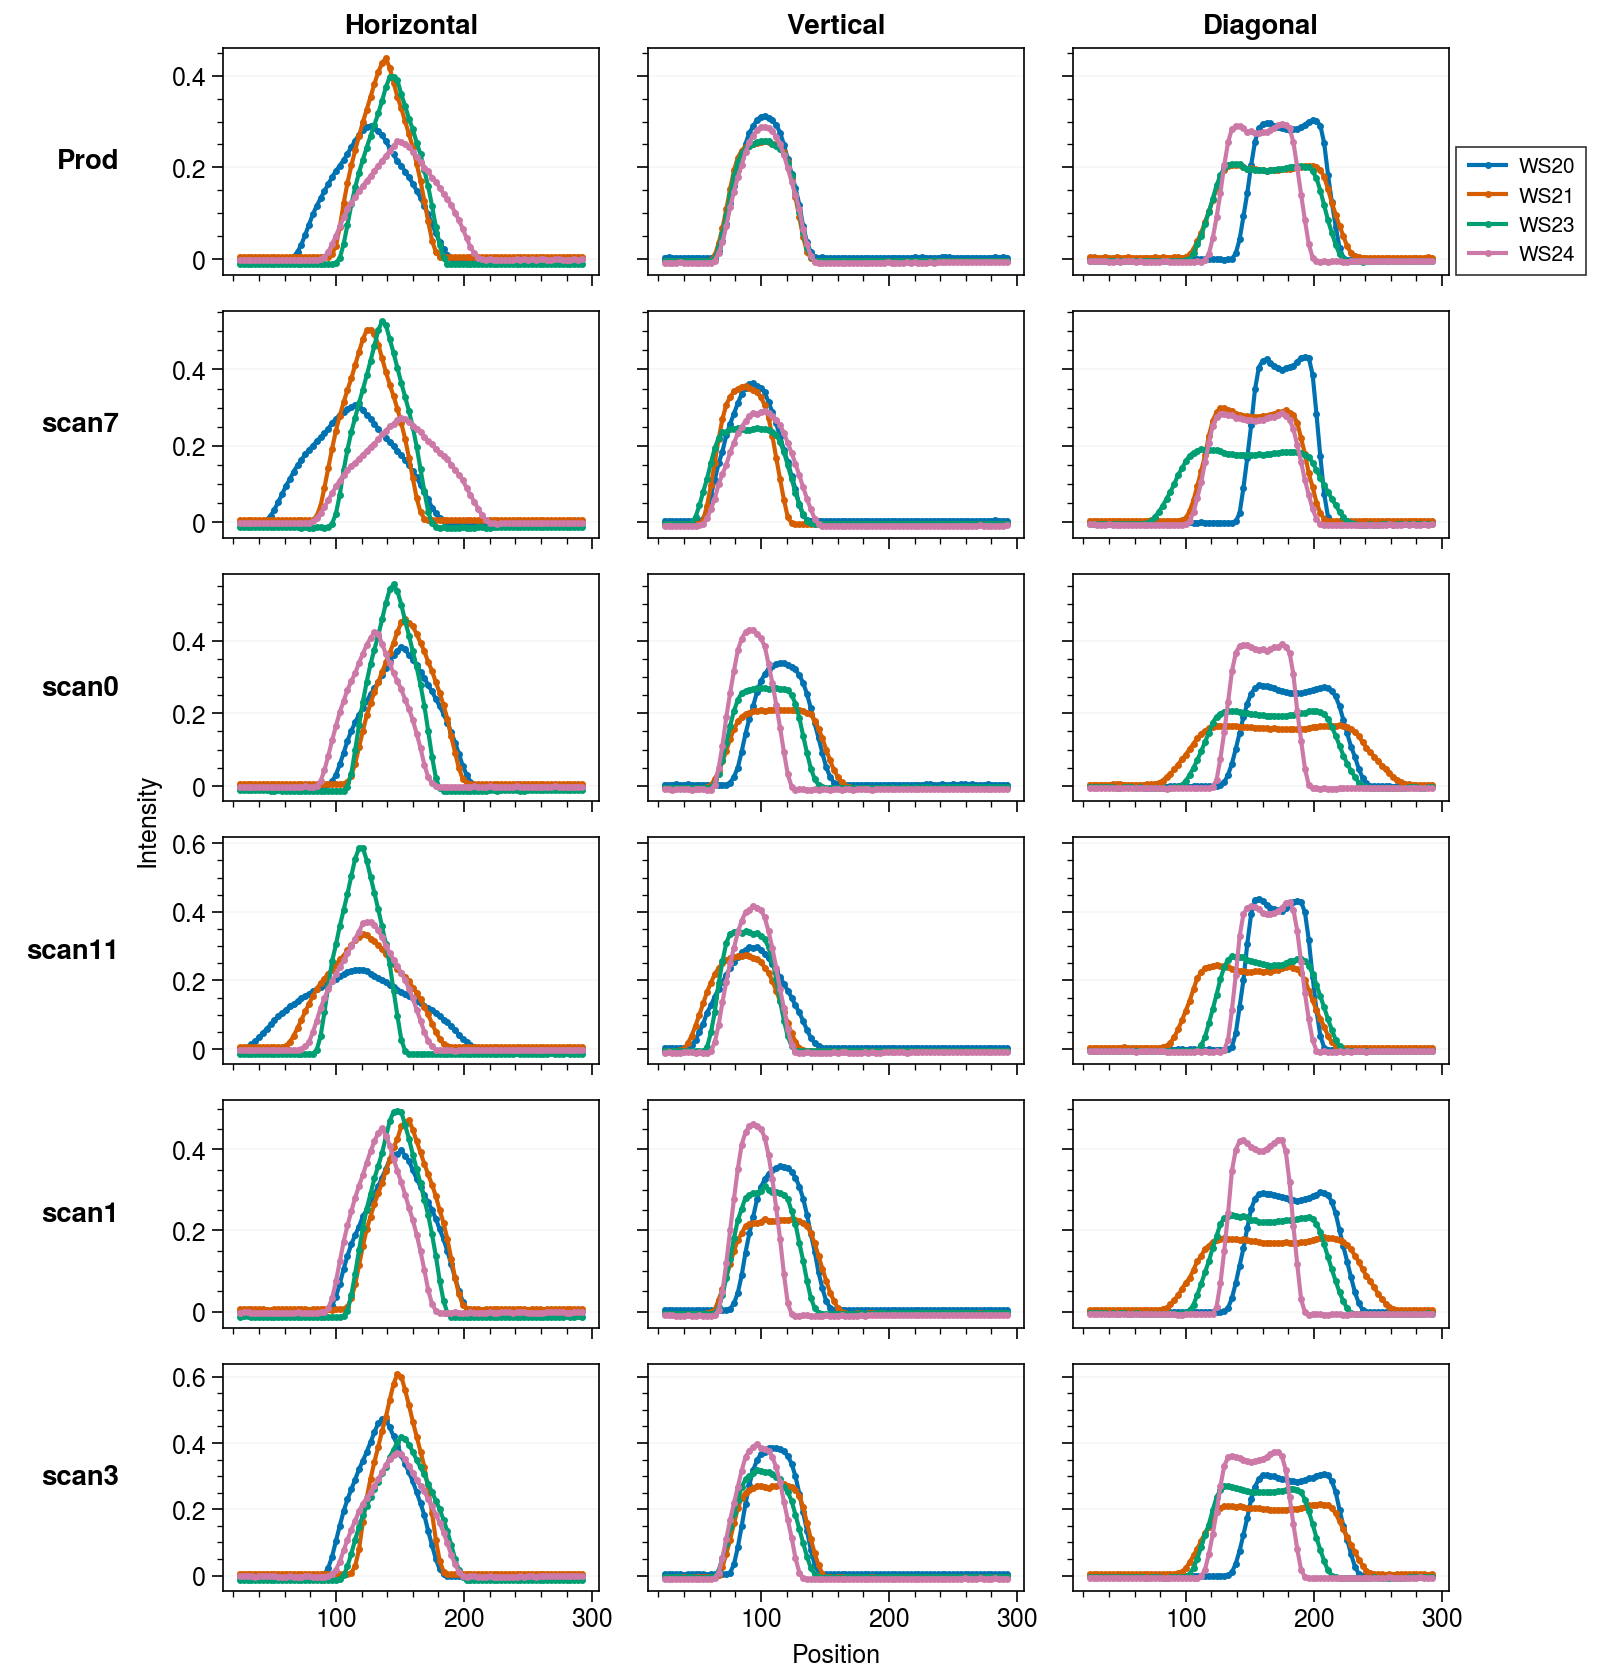

In [60]:
n_meas = len(data_list)
fig, axes = plot.subplots(nrows=n_meas, ncols=3, figsize=(8, 1.4*n_meas))
plt_kws = dict(legend=False, marker='.', ms=3)

for i, data in enumerate(data_list):
    for ws_id in ws_ids:
        for ax, key in zip(axes[i, :], ['xraw', 'yraw', 'uraw']):
            data[ws_id][['pos', key]].plot('pos', ax=ax, **plt_kws)
axes.format(xlabel='Position', ylabel='Intensity', grid=False, 
            toplabels=['Horizontal', 'Vertical', 'Diagonal'],
            leftlabels=filetags)
axes[0, -1].legend(labels=ws_ids, fontsize='small', loc=(1.02, 0), ncols=1)
for ax in axes:
    ax.grid(axis='y')

### Estimate moments from profiles 

## Reconstruct beam moments

Collect the transfer matrices calculated from the online model in OpenXAL.

In [45]:
transfer_mats = []
for i in scan_indices:
    matrix_elems_at_each_ws = np.loadtxt('./transfer_mat_elems_{}.dat'.format(i))
    # Each row gives the 16 elements at a different wire-scanner in the order
    # (WS02, WS20, WS21, WS23, WS24). We didn't take data from WS02, so skip the
    # first row. = 
    for matrix_elements in matrix_elems_at_each_ws[1:]:
        transfer_mats.append(matrix_elements.reshape((4, 4)))
transfer_mats = np.array(transfer_mats)
print('transfer_mats.shape =', transfer_mats.shape)

transfer_mats.shape = (20, 4, 4)
